<!-- # TEAM NAME: Monkeys -->
<!-- # TEAM MEMBERS: Aawab Mahmood, Nazif Mahamud, Kevin Wei -->

<!-- # Description: This code just houses all of our different modules and runs the models one at a time -->
<!-- # System:  Individually ran the ipynb(houses all of the modules together) in our own Google Colab systems. Some of us ran locally on VSCode using our GPUs as well. -->

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizerFast
from collections import Counter
import re
import csv

import sklearn
from torch import nn
import numpy as np

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix

In [24]:
NUM_CLASSES = 6
NUM_SENTIMENT = 3
NUM_HATE = 2

BATCH_SIZE=32
EPOCHS=1

In [ ]:
trainDatasetPath = './train.csv'

class ToxicCommentsRobertaDataset(Dataset):
    def __init__(self, path, columnName, tokenizer, maxLength=512):
        self.texts = []
        self.labels_list = []
        self.tokenizer = tokenizer
        self.maxLength = maxLength

        with open(path, encoding='utf-8') as f:
            reader = csv.reader(f)
            header = next(reader)
            textColIndex = header.index(columnName)
            labelColIndices = [
                header.index(label)
                for label in [
                    "toxic",
                    "severe_toxic",
                    "obscene",
                    "threat",
                    "insult",
                    "identity_hate",
                ]
            ]
            printed = False
            for rowIndex, row in enumerate(reader):
                text = row[textColIndex]
                # Store label columns independently
                labels = [int(row[labelColIndex]) for labelColIndex in labelColIndices] 

                self.texts.append(text)
                self.labels_list.append(labels)

        self.labels = torch.tensor(self.labels_list, dtype=torch.float32) 

        # Calculate weights independently per label
        pos_labels = self.labels.sum(dim=0)
        neg_labels = self.labels.shape[0] - pos_labels 
        self.weights = neg_labels/pos_labels 

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index: int):
        text = self.texts[index]
        labels = self.labels[index]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.maxLength,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": labels,
        }

In [ ]:
class distilRB_base(nn.Module):
    def __init__(self, multilabel: bool=False):
        super(distilRB_base, self).__init__()
        self.base_model = AutoModel.from_pretrained("distilbert/distilroberta-base")
        self.activation = nn.Linear(self.base_model.config.hidden_size, NUM_CLASSES if multilabel else 1)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        inter = self.base_model(input_ids, attention_mask)
        pooled = inter.pooler_output

        yHat = self.activation(pooled)
        return yHat

class distilRB_hate(nn.Module):
    def __init__(self, multilabel: bool=False):
        super(distilRB_hate, self).__init__()
        self.base_model = AutoModel.from_pretrained("distilbert/distilroberta-base")
        self.hate_model = AutoModelForSequenceClassification.from_pretrained("tomh/toxigen_roberta")
        
        for param in self.hate_model.parameters():
            param.requires_grad = False

        self.activation = nn.Linear(self.base_model.config.hidden_size + NUM_HATE, NUM_CLASSES if multilabel else 1)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        inter = self.base_model(input_ids, attention_mask)
        pooled = inter.pooler_output
        hate_signal = self.hate_model(input_ids, attention_mask).logits
        combined = torch.cat([pooled, hate_signal], dim=1)

        yHat = self.activation(combined)
        return yHat


class distilRB_sem(nn.Module):
    def __init__(self, multilabel: bool=False):
        super(distilRB_sem, self).__init__()
        self.base_model = AutoModel.from_pretrained("distilbert/distilroberta-base")
        self.sent_anal = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

        for param in self.sent_anal.parameters():
            param.requires_grad = False

        self.activation = nn.Linear(self.base_model.config.hidden_size + NUM_SENTIMENT, NUM_CLASSES if multilabel else 1)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        inter = self.base_model(input_ids, attention_mask)
        pooled = inter.pooler_output
        sentiment = self.sent_anal(input_ids, attention_mask).logits
        combined = torch.cat([pooled, sentiment], dim=1)

        yHat = self.activation(combined)
        return yHat

class distilRB_combine(nn.Module):
    def __init__(self, multilabel: bool=False):
        super(distilRB_combine, self).__init__()
        self.base_model = AutoModel.from_pretrained("distilbert/distilroberta-base")
        self.sent_anal = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
        self.hate_model = AutoModelForSequenceClassification.from_pretrained("tomh/toxigen_roberta")

        for param in self.sent_anal.parameters():
            param.requires_grad = False

        for param in self.hate_model.parameters():
            param.requires_grad = False

        self.activation = nn.Linear(
            self.base_model.config.hidden_size + NUM_SENTIMENT + NUM_HATE, NUM_CLASSES if multilabel else 1
        )

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        inter = self.base_model(input_ids, attention_mask)
        pooled = inter.pooler_output

        sentiment = self.sent_anal(input_ids, attention_mask).logits
        hate = self.hate_model(input_ids, attention_mask).logits
        
        combined = torch.cat([pooled, sentiment, hate], dim=1)
        
        yHat = self.activation(combined)
        return yHat


In [ ]:
def trim(batch: dict[str, torch.tensor]):
    masks = batch['attention_mask']
    maxLen = torch.max(torch.sum(masks, dim=1))

    if batch['labels'].shape == batch['input_ids'].shape:
        batch['labels'] = batch['labels'][:, :maxLen]

    batch['input_ids'] = batch['input_ids'][:, :maxLen]
    batch['attention_mask'] = batch['attention_mask'][:, :maxLen]

    return batch

def trainModel(model, dataset: Dataset, lr=1e-5, weight_decay=1e-3):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    optimizer = torch.optim.AdamW(lr=lr, weight_decay=weight_decay, params=model.parameters())


    trainDataLoader = DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)
    lossPerEpoch = []

    criterion = torch.nn.BCEWithLogitsLoss()

    model.train()
    for epoch in range(EPOCHS):
        losses = []
        for batch in trainDataLoader:
            batch = trim(batch)

            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}

            labels = batch["labels"].to(device)
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(**inputs).squeeze()

            loss = criterion(outputs, labels)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        lossPerEpoch.append(losses)

    return lossPerEpoch

In [29]:
class ToxicCommentsRobertaEvalDataset(Dataset):
    def __init__(self, df, tokenizer, maxLength=512):
        self.df = df
        self.tokenizer = tokenizer
        self.maxLength = maxLength

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.df.iloc[index]['comment_text']
        labels = self.df.iloc[index][['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values.astype(int)
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.maxLength,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(labels, dtype=torch.float32),
        }

In [ ]:
def evalModel(model, dataset: ToxicCommentsRobertaEvalDataset, device='cuda'):
    model.to(device)
    model.eval()

    evalDataLoader = DataLoader(dataset, batch_size=BATCH_SIZE)

    preds = []
    trueLabels = []

    with torch.no_grad():
        for batch in evalDataLoader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(device)

            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(**inputs).squeeze()

            probs = torch.sigmoid(outputs)
            pred = (probs > 0.5).int().cpu().numpy()

            preds.extend(pred)  
            trueLabels.extend(labels.cpu().numpy())  

    preds = np.array(preds)
    trueLabels = np.array(trueLabels) 

    print(preds.shape)
    print(trueLabels.shape)

    cm = multilabel_confusion_matrix(trueLabels, preds)

    f1 = sklearn.metrics.f1_score(trueLabels, preds, average='macro')
    accuracy = sklearn.metrics.accuracy_score(trueLabels, preds)
    precision = sklearn.metrics.precision_score(trueLabels, preds, average='macro')
    recall = sklearn.metrics.recall_score(trueLabels, preds, average='macro')

    metrics = {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1)
    }

    return metrics, preds, trueLabels, cm

In [ ]:
def memory_stats():
    print(torch.cuda.memory_allocated()/1024**2)
    print(torch.cuda.memory_cached()/1024**2)


if __name__ == '__main__' :
    memory_stats()
    torch.cuda.empty_cache()
    memory_stats()
    tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
    toxicDataset = ToxicCommentsRobertaDataset(trainDatasetPath, 'comment_text', tokenizer=tokenizer)

    model = distilRB_sem(multilabel=True)

    lossPerEpoch = trainModel(model, toxicDataset)

    torch.cuda.empty_cache()

5258.56982421875
7910.0
5258.56982421875
5996.0


<ipython-input-32-5b575312a82b>:3: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print(torch.cuda.memory_cached()/1024**2)


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
dfTest = pd.read_csv('test.csv', quotechar='"')
dfLabels = pd.read_csv('test_labels.csv')

dfMerged = pd.merge(dfTest, dfLabels, on='id', how='left')
dfFiltered = dfMerged[dfMerged['toxic'] != -1] 

evalDataset = ToxicCommentsRobertaEvalDataset(dfFiltered, tokenizer)

# Eval
metrics, preds, true_labels, cm  = evalModel(model, evalDataset)
print(metrics)

(63978, 6)
(63978, 6)
{'accuracy': 0.8812716871424552, 'precision': 0.5539756857021895, 'recall': 0.6419139899224668, 'f1': 0.5864197296656346}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize(dfFiltered, metrics, lossPerEpoch, trueLabels, preds, cm):
    dfMelted = dfFiltered.melt(
        id_vars=['id', 'comment_text'],
        value_vars=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
        var_name='labels',
        value_name='label_value' 
    )

    dfMelted = dfMelted[dfMelted['label_value'] != -1]

    plt.figure(figsize=(8, 6))
    sns.countplot(x='labels', data=dfMelted[dfMelted['label_value'] == 1])
    plt.title('Distribution of Labels in Test Data')
    plt.xlabel('Label (0: Non-Toxic, 1: Toxic)')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')  
    plt.show()


    labelNames = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'] 
    f1Scores = sklearn.metrics.f1_score(trueLabels, preds, average=None)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=labelNames, y=f1Scores)
    plt.title('F1 Score per Label')
    plt.ylim(0, 1)
    plt.ylabel('F1 Score')
    plt.xticks(rotation=45, ha='right') 
    plt.show()


    labelNames = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    numLabels = len(labelNames)

    cm_all = np.zeros((2, 2), dtype=int) 
    for i in range(numLabels):
        cm_all += cm[i] 

    plt.figure(figsize=(6, 4)) 
    sns.heatmap(cm_all, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Overall Confusion Matrix (All Labels)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


    plt.figure(figsize=(10, 6))
    for losses in lossPerEpoch:
        plt.plot(range(len(losses)), losses)
    plt.title('Training Loss per Epoch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.show()

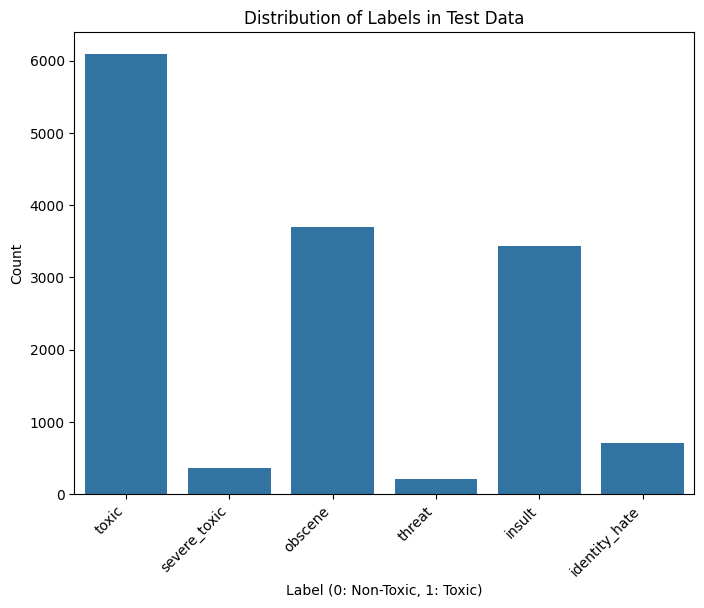

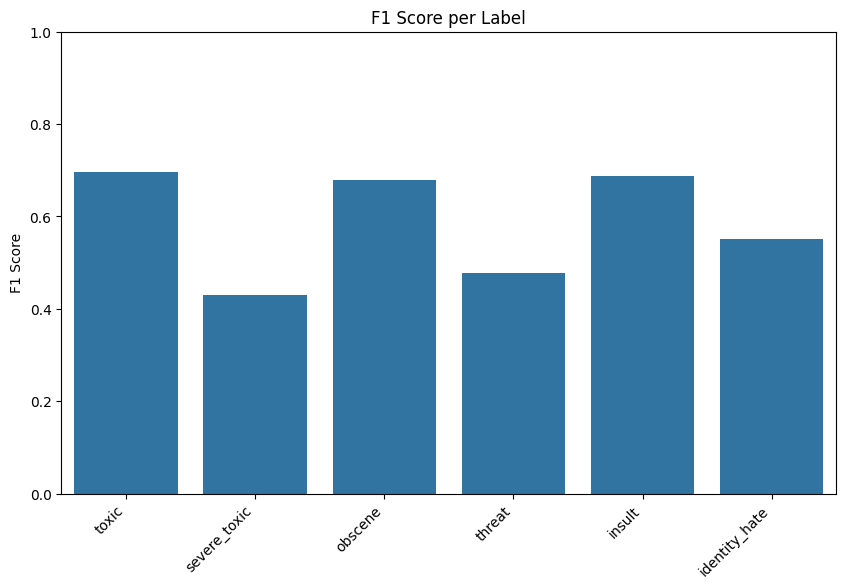

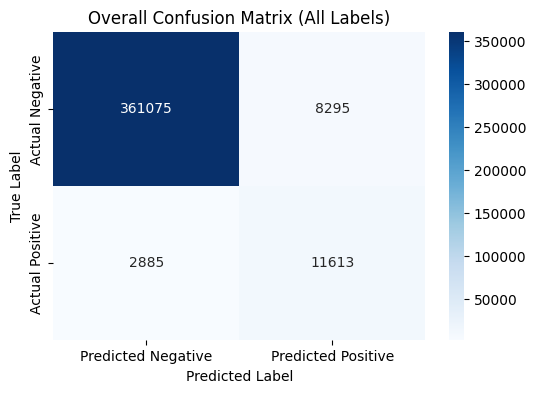

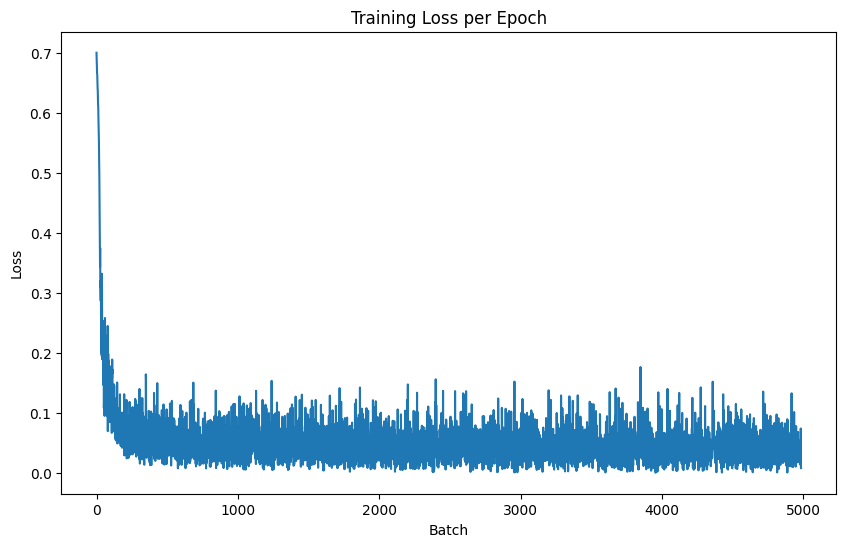

In [ ]:
visualize(df_filtered, metrics, loss_per_epoch, true_labels, preds, cm)